# Tutorial 1: Enhanced sampling overview

In this tutorial we'll give an inductive (and maybe naive) motivation for the need of enhanced sampling in molecular dynamics (MD).
We will show two `OPES` flavors, discussing their features from a more hands-on perspective and we'll try to provide a hint of the role that collective variables (CVs) have in enhanced sampling methods.

This will also be a good opportunity to get familiar with two code resoruces: `PLUMED` and `mlcolvar`.

- `PLUMED` is an open-source plugin for to perform free-energy calcualtions, apply enhnaced sampling protocols and analyzing MD trajectories.
- `mlcolvar` is an open-source python library mostly devoted to the development and use of machine learning collective variables. As a bonus, the library contains a whole bunch of utilities that are extremely helpful in everyday life, especially when interfacing with `PLUMED`

**DISCLAIMER**: here we focus on methods, so we'll stick to a simple example to make that easier! Nonetheless, all the things we'll show have found plenty of applications to challenging systems, if you are interested we can have a chat in the following days!

# Import modules

In [1]:
# general libs
import torch
import numpy as np
import matplotlib.pyplot as plt
import subprocess

# mlcolvar modules
from mlcolvar.utils.plot import paletteFessa

# Our hero: the Muller-Brown potential

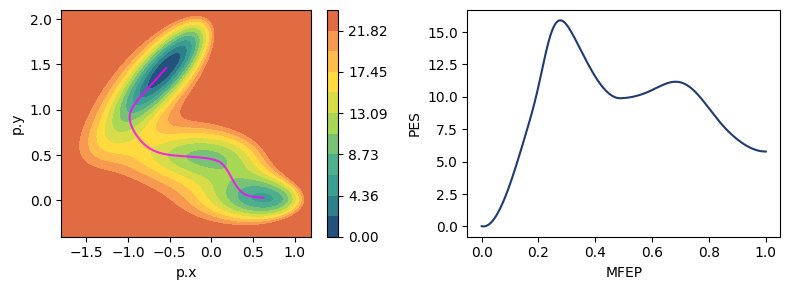

In [2]:
# utils for Muller-Brown potential: plot functions on MB space, MB analytic formula function, MB minimum free energy path
from mlcolvar.utils.plot import plot_isolines_2D, muller_brown_potential, muller_brown_mfep

fig, axs = plt.subplots(ncols=2, figsize=(8,3))

# 2D potential energy surface (PES)
ax = axs[0]
mfep = muller_brown_mfep()
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=True)
ax.plot(mfep[:, 0], mfep[:, 1], color='magenta', alpha=0.8)
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

# 1D projection of PES along the minimum free energy path (MFEP)
ax = axs[1]
fes_mfep = muller_brown_potential(mfep[:, 0], mfep[:, 1])
ax.plot(np.linspace(0,1,200), fes_mfep, c=paletteFessa[0])
ax.set_xlabel('MFEP')
ax.set_ylabel('PES')
plt.tight_layout()
plt.show()

# Why do we need enhanced sampling?

At low temperature (kBT=1) the barriers are so high that it would take forever to cross them

<center><img src="../figures/rare_event.png" width="600" /></center>

$$\text{For M\"uller:} \quad 1\,\text{forever} \simeq e^{\Delta G / k_BT} \simeq 10^6 $$ 

#### T=1
We can try to se what happens if we try to run a simulation starting from the two basins, so we can start familiarizing with the system and the machinery

In [3]:
RUN_SIMULATION = "bash submission_scripts/run_unbiased_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_unbiased_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_unbiased_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

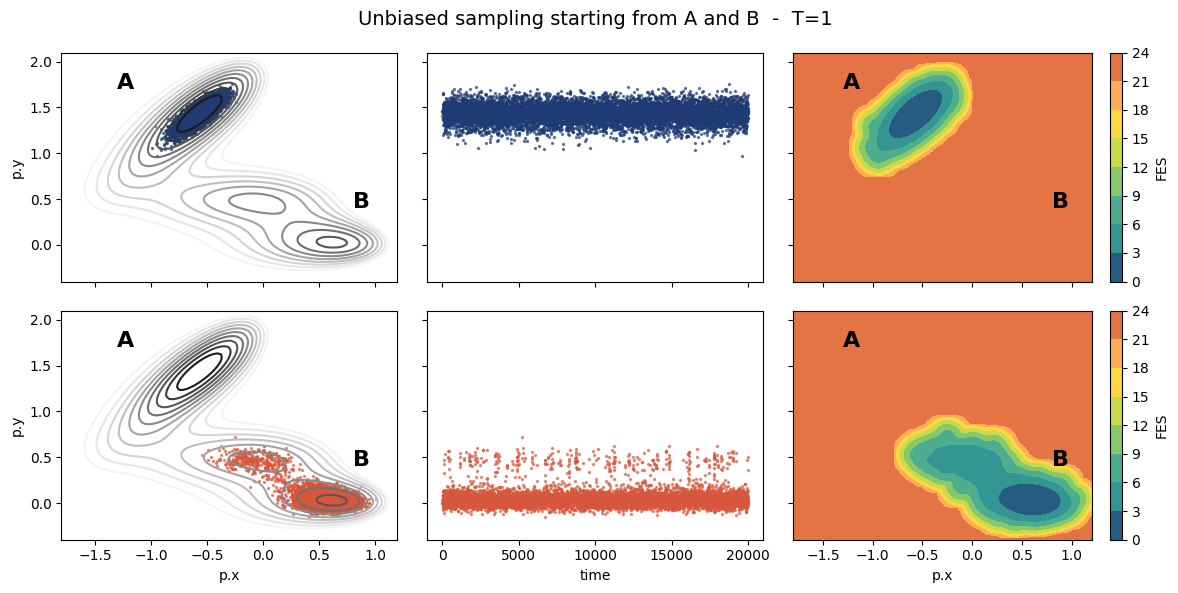

In [5]:
# utils to load PLUMED colvar files easily into pandas dataframe and compute free energy surface (FES)
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.fes import compute_fes

# load data
file_names = ['simulations/unbiased_sims/A/COLVAR', 
              'simulations/unbiased_sims/B/COLVAR']

sampling = load_dataframe(file_names=file_names,
                          start=0,
                          stop=10000,
                          stride=1)

# As we will do some similar tests, we can write a function to plot the results
def plot_simulations_unbiased(title, data, kbt):
    # create plot
    fig, axs = plt.subplots(2,3,figsize=(12,6), gridspec_kw={'width_ratios' : [9,9,10]})
    # make title
    fig.suptitle(f"Unbiased sampling starting from A and B  -  {title}", fontsize=14)
    
    # we plot the data obtained starting from A and B
    for i,s in enumerate(['A', 'B']):
        # scatter plot in x,y space
        ax = axs[i, 0]
        plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
        temp = data[data['walker'] == i]
        temp.plot.scatter('p.x', 'p.y',s=2, alpha=0.6, color=paletteFessa[0 + 6*i], ax=ax)
        # make it nicer
        ax.text(-1.3, 1.7, 'A', fontsize=16, fontweight='bold')
        ax.text(0.8, 0.4, 'B', fontsize=16, fontweight='bold')
        if i==0: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])

        # time series of y coordinates
        ax = axs[i, 1]
        temp.plot.scatter('time', 'p.y', c=paletteFessa[0 + 6*i], s=2, alpha=0.6, ax=ax)
        # make it nicer
        ax.set_ylim((-0.4, 2.1))
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        if i==0: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
        
        # plot free enery surface estimate
        ax = axs[i, 2]
        fes,bins,_,_ = compute_fes(temp[['p.x', 'p.y']].values, 
                                   kbt=kbt, 
                                   plot=True, 
                                   num_samples=200, 
                                   eps=1e-8, 
                                   bandwidth=0.05, 
                                   plot_max_fes=24, 
                                   ax=ax, 
                                   bounds=((-1.8, 1.2), (-0.4, 2.1)))
        # make it nicer
        ax.text(-1.3, 1.7, 'A', fontsize=16, fontweight='bold')
        ax.text(0.8, 0.4, 'B', fontsize=16, fontweight='bold')
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        if i==0: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel('p.x')

    plt.tight_layout()
    plt.show()    

# We can use it to plot our first data
plot_simulations_unbiased(title='T=1', data=sampling, kbt=1)

There's not much happening, as expected we just explore the bottom of the metastable state we were starting from.

We can try to raise the temperature a little bit and see if this improves

#### T=1.5

In [35]:
RUN_SIMULATION = "bash submission_scripts/run_unbiased_highT_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_unbiased_highT_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_unbiased_highT_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

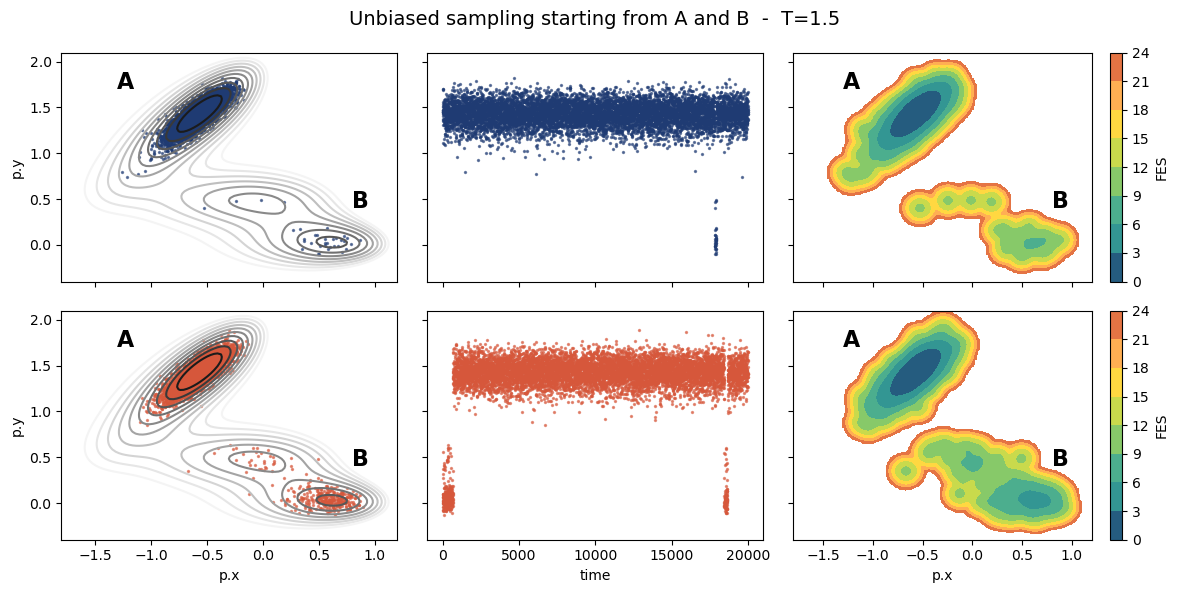

In [150]:
# load data
file_names=['simulations/unbiased_highT_sims/A/COLVAR', 
           'simulations/unbiased_highT_sims/B/COLVAR']
sampling = load_dataframe(file_names=file_names,
                          start=0,
                          stop=10000,
                          stride=1)

# plot data
plot_simulations_unbiased(title='T=1.5', data=sampling, kbt=1.5)

It gets a little bit better but it's still far from efficient, we only have a very few transitions.

Let's try to heat it more (kBT=3)

#### T=3

In [47]:
RUN_SIMULATION = "bash submission_scripts/run_unbiased_crazyT_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_unbiased_crazyT_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_unbiased_crazyT_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

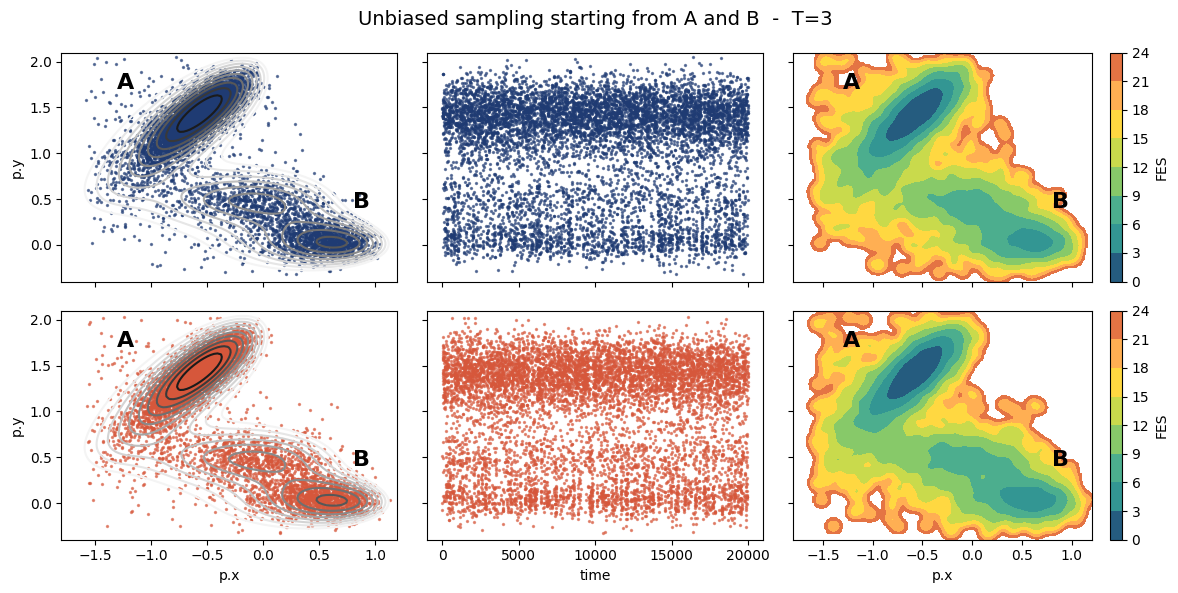

In [6]:
# load data
file_names=['simulations/unbiased_crazyT_sims/A/COLVAR', 
            'simulations/unbiased_crazyT_sims/B/COLVAR']
sampling = load_dataframe(file_names=file_names,
                          start=0,
                          stop=10000,
                          stride=1)

# plot data
plot_simulations_unbiased(title='T=3', data=sampling, kbt=3)

Raising the temperature can help, but you must be carfeul!

This is a toy model, imagine what can happen with a protein!

Raising the temperature doesn't give much *control* on your simulations!

# Enhanced sampling 101

We want to promote the transitions between the states with *as much control as possible*

Many enhanced sampling methods are based on the addition of a **external bias potential** $V(x)$ to the natural potential $U(x)$ so as to mitigiate the effect of large free energy barriers and promote transitions.

<center><img src="../figures/prob_dist.png" width="600" /></center>


## Metadynamics (MetaD)
The bias is built on-the-fly by depositing repulsive Gaussians as we move in the phase space until we eventually fill the basins
$$V_n(\textbf{s}) = \sum_k^n \exp[-\frac{\beta V_{k-1}(\textbf{s}_k)}{\gamma-1}] \textbf{G}(\textbf{s}, \textbf{s}_k) \qquad\xrightarrow{n \rightarrow \infty}\qquad V_\gamma(\textbf{s}) = - (1 - \frac{1}{\gamma})F(\textbf{s}) + c(t)$$

<center><img src="../figures/metad.png" width="500" /></center>

---

## On-the-fly Probability Enhanced Sampling (OPES)
It's an evolution of MetaD that is faster and more stable. Here the focus for the bias construction is shifted from the energy to the probability distribution.
The OPES bias aims at sampling a **target probability distribution** $p^{tg}$
$$ V(\textbf{s}) = \frac{1}{\beta} \ln \frac{P(\textbf{s})}{p^{tg}(\textbf{s})}$$
For instance, the well-tempered distribution
$$ p^{tg}(\textbf{s}) = p^{WT}(\textbf{s}) \propto [P(\textbf{s})]^{1/\gamma}$$

Not only, it also have different flavours that can drive different types of sampling

### OPES-Metad
Best solution for converging free energies. The bias quickly becomes quasi-static but requires good CVs.

$$V_n(\textbf{s}) = (1 - \frac{1}{\gamma})\frac{1}{\beta}\ln\big(\frac{P_n(\textbf{s}\big)}{Z_n} + \epsilon) \qquad \text{with}\qquad P_n(\textbf{s}) = \frac{\sum_k^n w_k G(\textbf{s}, \textbf{s}_k)}{\sum_k^n w_k} \quad\text{i.e., KDE}$$


### OPES-Explore
Similar to MetaD (but still better). The bias is updated more aggresively to promote more transitions, even if they are less equilibrated. It can be helpful when the CVs are suboptimal.
$$V_n(\textbf{s}) = (\gamma - 1) \frac{1}{\beta}\ln(\frac{p^{WT}(\textbf{s})}{Z_n} + \epsilon)  \qquad \text{with}\qquad p^{WT}_n(\textbf{s}) = \frac{1}{n}\sum_k^n G(\textbf{s}, \textbf{s}_k)$$


### OPES-Flooding
It fills only **one** basin to collect reactive trajectories that can be used to compute rates from biased simulations as the bias does not affect the transition state.
<center><img src="../figures/flooding.png" width="500" /></center>



### OPES-Expanded
Ask Pablo, he did with Michele :)


# OPES-MetaD

Let's see if we can get any better using some enhaced sampling (luckily, it would be difficult to do worse)

## p.y metad

We can start witht the *standard* OPES flavor, `OPES-MetaD`. This is typically the best choice to have converged and accurate free energy estimation.

For now, we'll use `p.y` as a CV.

In [58]:
RUN_SIMULATION = "bash submission_scripts/run_opes_metad_y_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_opes_metad_x_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_opes_metad_x_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

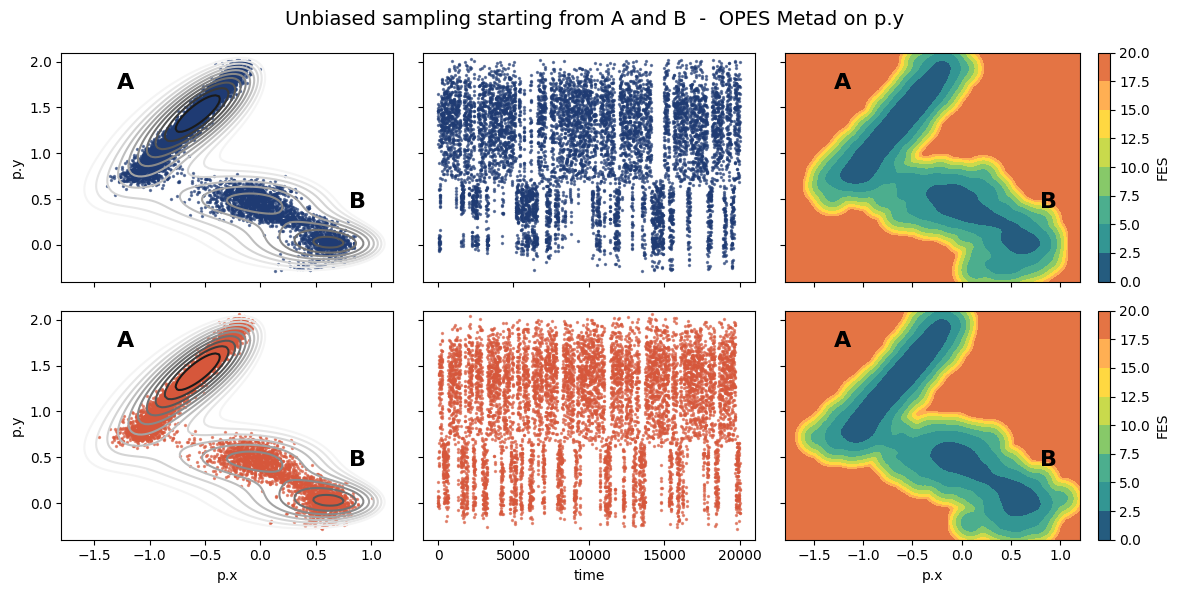

In [8]:
# load data
file_names= ['simulations/opes_metad_y/A/COLVAR', 
             'simulations/opes_metad_y/B/COLVAR']
sampling = load_dataframe(file_names=file_names,
                          start=0,
                          stop=10000,
                          stride=1)

# plot data
plot_simulations_unbiased(title='OPES Metad on p.y', data=sampling, kbt=1)

This way we can actually drive many transitions! But, we are happy, not super happy.

If we look closer at the results:
- We have many transitions between A and B, good
- The sampling on the TS is not optimal, not so good
- The FES is completely random, bad, extremely bad

**Question**: why is it so?

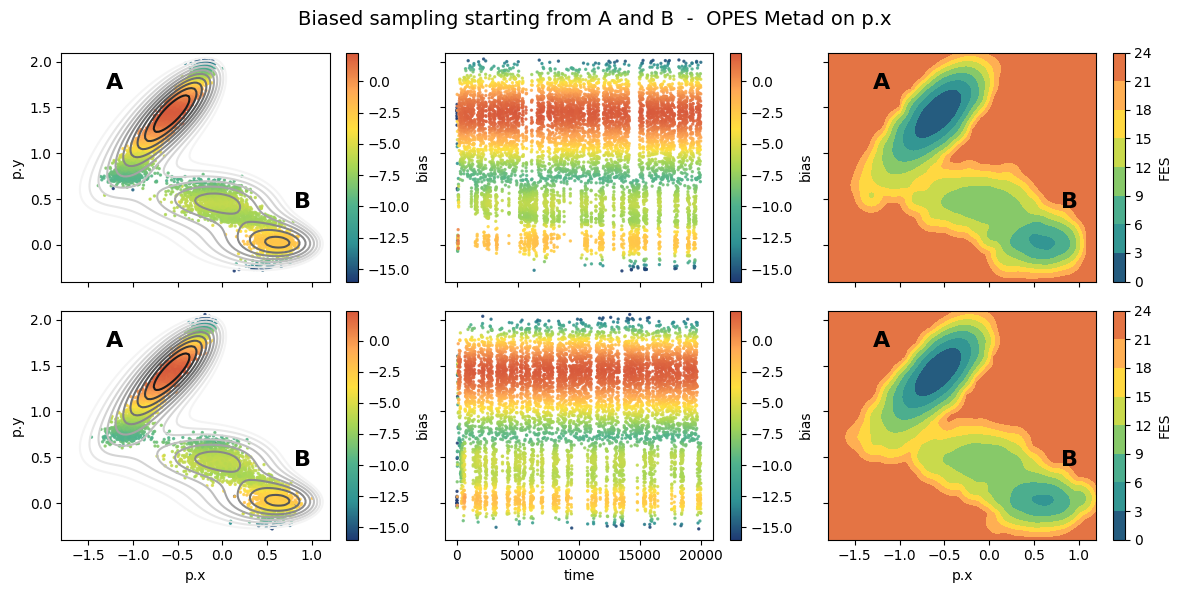

In [9]:
# plot data
def plot_simulations_biased(title, data, kbt, bias_name):
    # create plot
    fig, axs = plt.subplots(2,3,figsize=(12,6))
    # make title
    fig.suptitle(f"Biased sampling starting from A and B  -  {title}", fontsize=14)
    
    # we plot the data obtained starting from A and B, but we reweight them and color according to the bias
    for i,s in enumerate(['A', 'B']):
        # scatter plot in x,y space
        ax = axs[i, 0]
        plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
        temp = data[data['walker'] == i]
        cp = ax.scatter(temp['p.x'], temp['p.y'], c=temp[bias_name], s=2, alpha=0.8, cmap='fessa') # color with bias
        cbar = plt.colorbar(cp, ax=ax, label = 'bias')
        # make it nicer
        cbar.solids.set(alpha=1)
        ax.text(-1.3, 1.7, 'A', fontsize=16, fontweight='bold')
        ax.text(0.8, 0.4, 'B', fontsize=16, fontweight='bold')
        ax.set_ylabel('p.y')
        if i==0: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel('p.x')

        # time series of y coordinates
        ax = axs[i, 1]
        
        cp = ax.scatter(temp['time'], temp['p.y'], c=temp[bias_name], s=2, alpha=0.8, cmap='fessa') # color with bias
        cbar = plt.colorbar(cp, ax=ax, label = 'bias')
        # make it nicer
        cbar.solids.set(alpha=1)
        ax.set_ylim((-0.4, 2.1))
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        if i==0: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel('time')
            
        
        # plot free enery surface estimate
        ax = axs[i, 2]
        weights = np.exp(1/kbt*temp[bias_name].values) # compute weights
        fes,bins,_,_ = compute_fes(temp[['p.x', 'p.y']].values, 
                                   kbt=kbt, 
                                   weights=weights, # <--- reweight data
                                   plot=True, 
                                   num_samples=200, 
                                   eps=1e-8, 
                                   bandwidth=0.05, 
                                   plot_max_fes=24, 
                                   ax=ax, 
                                   bounds=((-1.8, 1.2), (-0.4, 2.1)))
        # make it nicer
        ax.text(-1.3, 1.7, 'A', fontsize=16, fontweight='bold')
        ax.text(0.8, 0.4, 'B', fontsize=16, fontweight='bold')
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        if i==0: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel('p.x')

    plt.tight_layout()
    plt.show()   

# we can see how the situation changes
plot_simulations_biased(title='OPES Metad on p.x', data=sampling, kbt=1, bias_name='opes.bias')

## p.x metad
Ok, what if we picked `p.x` as a CV?

In [72]:
RUN_SIMULATION = "bash submission_scripts/run_opes_metad_x_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_opes_metad_y_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_opes_metad_y_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

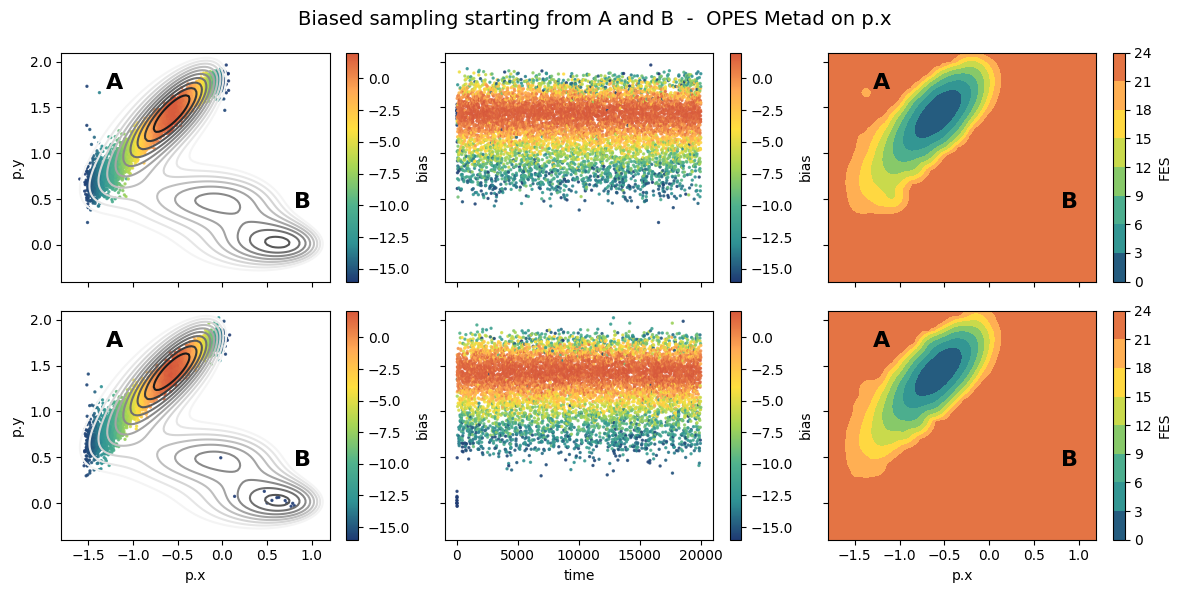

In [11]:
# load data
file_names = ['simulations/opes_metad_x/A/COLVAR', 
              'simulations/opes_metad_x/B/COLVAR']
sampling = load_dataframe(file_names=file_names,
                          start=0,
                          stop=10000,
                          stride=1)

# plot data
plot_simulations_biased(title='OPES Metad on p.x', data=sampling, kbt=1, bias_name='opes.bias')

GREAT! It doesn't work (almost) at all!

**Question**: what is wrong with x?

# What is a (good) collective variable?

A good collective variable, in general, should:
- Operate a dimensionality reduction
- Distinguish the metstable states (and the TS)
- Encode the slowest modes of the process

In most cases, CVs are not so easy to find.
Conventionally, they have been chosen by chemical/physical intuition relying on physical descriptors such as distances, angles, coordination numbers etc..

We can have a look at how x and y behave

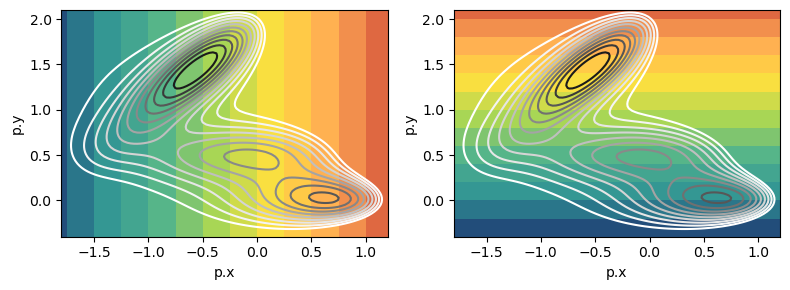

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8,3))

# visualize x
ax = axs[0]
plot_isolines_2D(lambda x,y: x , ax=ax, colorbar=False)
plot_isolines_2D(muller_brown_potential, ax=ax, colorbar=False, mode='contour', levels=np.linspace(0,24, 12))
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

# visualize y
ax = axs[1]
plot_isolines_2D(lambda x,y: y , ax=ax, colorbar=False)
plot_isolines_2D(muller_brown_potential, ax=ax, colorbar=False, mode='contour', levels=np.linspace(0,24, 12))
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

plt.tight_layout()
plt.show()

However, the conventional approach is raher limiting as it's difficult to identify single variables that can really be collective.

One alternative can be, for example, to combine some variables to make them more *collective*.

 The easiest approach is to combine them linearly

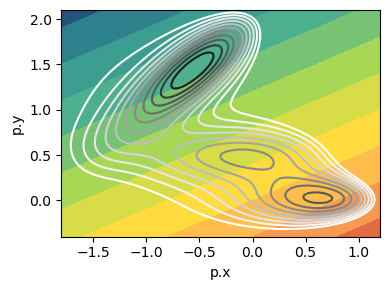

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(4,3))

# cv = 0.5*x-y
plot_isolines_2D(lambda x,y: 0.5*x-y , ax=ax, colorbar=False)
plot_isolines_2D(muller_brown_potential, ax=ax, colorbar=False, mode='contour', levels=np.linspace(0,24, 12))
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

plt.tight_layout()
plt.show()

We can test it

In [ ]:
import subprocess

RUN_SIMULATION = "bash submission_scripts/run_opes_metad_x-y_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_opes_metad_x-y_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_opes_metad_x-y_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

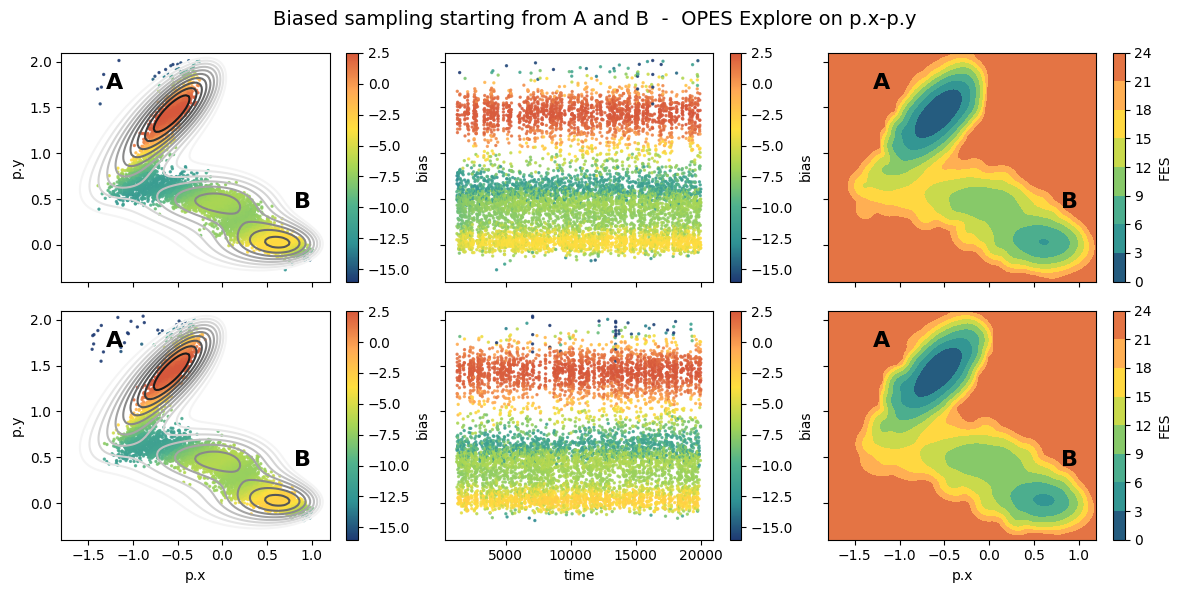

In [12]:
# load data
file_names = ['simulations/opes_metad_x-y/A/COLVAR', 
              'simulations/opes_metad_x-y/B/COLVAR']


sampling = load_dataframe(file_names=file_names,
                          start=500,
                          stop=10000,
                          stride=1)

# plot data
plot_simulations_biased(title='OPES Explore on p.x-p.y', data=sampling, kbt=1, bias_name='opes.bias')

It's still not perfect but it's way better thatn y alone! Look at that TS sampling!

# BONUS: OPES-Explore

`OPES-Explore` is another flavor of OPES that builds the bias more aggressively so to facilitate transitions even when the CVs are not optimal. This, of course, comes at the cost of a slower convergence of free energies and drives the system more eventually driving out-of-equilibrium.

Nonetheless, it could be a useful tool in some cases, for example, as the name suggests, for exploring a landscape we only partially know.

## p.x explore

For example, we can try to improve a little bit the performances of our poor `p.x`

In [93]:
RUN_SIMULATION = "bash submission_scripts/run_opes_explore_x_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_opes_explore_x_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_opes_explore_x_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

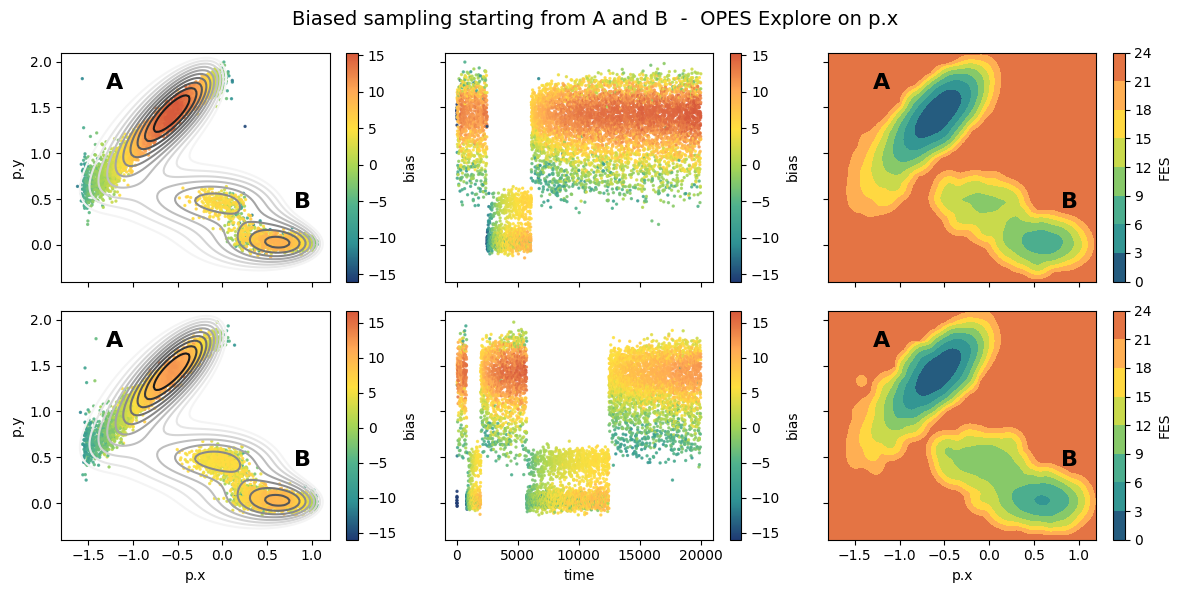

In [14]:
# load data
file_names = ['simulations/opes_explore_x/A/COLVAR', 
              'simulations/opes_explore_x/B/COLVAR']

sampling = load_dataframe(file_names=file_names,
                          start=0,
                          stop=10000,
                          stride=1)

# plot data
plot_simulations_biased(title='OPES Explore on p.x', data=sampling, kbt=1, bias_name='opes.bias')

It actually improves! At least we get some transitions! Imagine that we only knew one of the state in the beginning..

## p.y explore

But what happens if we use it on relatively good CV?

In [112]:
RUN_SIMULATION = "bash submission_scripts/run_opes_explore_y_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_opes_explore_y_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_opes_explore_y_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

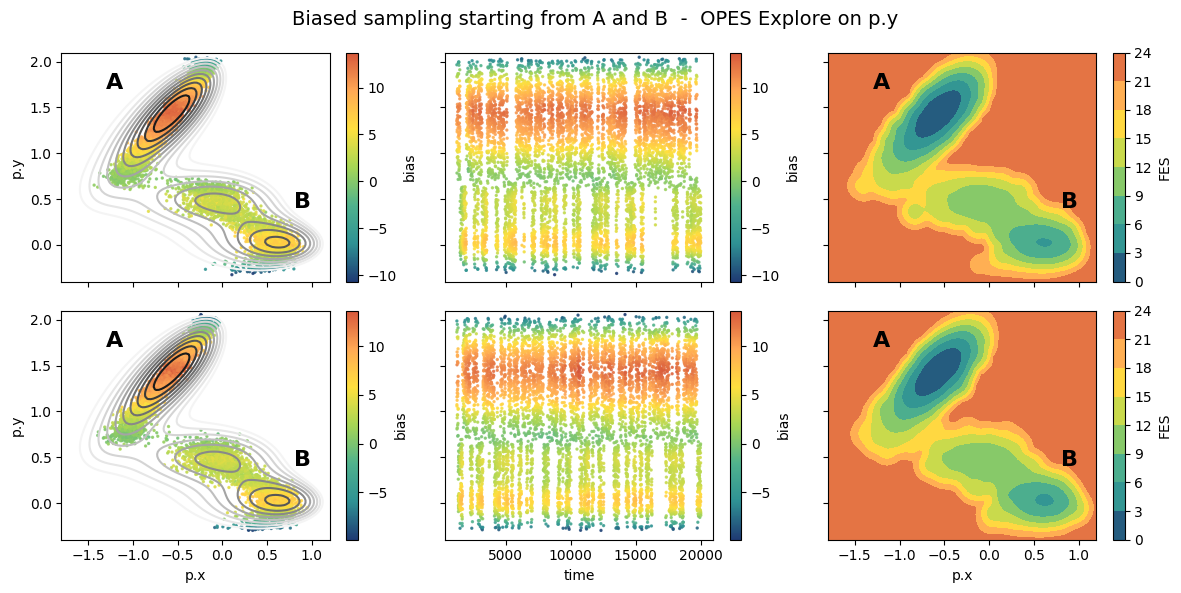

In [15]:
# load data
file_names = ['simulations/opes_explore_y/A/COLVAR', 
              'simulations/opes_explore_y/B/COLVAR']

sampling = load_dataframe(file_names=file_names,
                          start=500,
                          stop=10000,
                          stride=1)

# plot data
plot_simulations_biased(title='OPES Explore on p.y', data=sampling, kbt=1, bias_name='opes.bias')

The simulation is almost as good as with `OPES-MetaD`, however, the system has been driven more out of equilibrium, thus sampling 'useless' regions of the space.